# Reinforcement Learning and Q-Learning
- RL vs DP : 환경의 모델을 몰라도 학습할 수 있는가?
- MDP(Markov Decision Process)로 정의되는 문제를 풀 때 중요한 것은 **벨만 기대 방정식의 기댓값인 $E_\pi$를 어떻게 계산하는가?**
- 인간도 어떤 것을 판단할 대 항상 정확한 정보를 근거로 판단하지 않음
- Policy Evalutaion $\rightarrow$ Predict
    - 강화학습의 예측엔 Monte-Carlo, 시간차 예측이 있음
- Policy Iteration(Policy Evaluation + Policy Improvement) $\rightarrow$ Control
    - SARSA와 Q-Learning이 있음
- 고전 강화학습 알고리즘들은 현재 **젠젠** 사용되지 않지만, 현재의 알고리즘들은 이들을 기반으로 발전됐다!
    - 그러므로 공부해라 닝겐아

### Monte-Carlo Approximation으로 원의 넓이 추정하기
- 우리는 원의 넓이를 구하는 식을 알고 있다. ($S(\text{circle})=\pi r^2$)
- 위의 방정식을 몰라도 넓이를 구할 수 있을 것인가?
- 수없이 점을 뿌려서 비율로 근사하자!
- 주가 예측 시뮬레이션에서도 많이 사용해본 Monte-Carlo, 여기서 복습하기

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

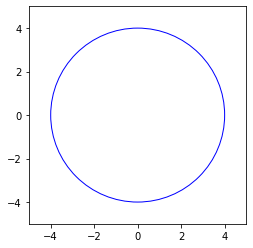

In [2]:
# https://mathcoding.tistory.com/21?category=756794
circle_center = (0, 0)
circle_radius = 4

c = plt.Circle(circle_center, circle_radius, fc='w', ec='b')

a = plt.axes(xlim=(-5, 5), ylim=(-5, 5))
a.add_patch(c)
a.set_aspect('equal')

plt.show()

In [3]:
# random sample 생성 코드
def MonteCarloSampling(xlim, ylim):
    xmin, xmax, ymin, ymax = xlim + ylim
    crd = (
        np.random.uniform(xmin, xmax), 
        np.random.uniform(ymin, ymax)
    )
    return crd


# 원 안의 점인지 확인
def is_in_circle(crd, r=1):
    x, y = crd
    is_circle = int(x ** 2 + y ** 2 <= r ** 2)
    return is_circle

In [4]:
xlim, ylim = (-5, 5), (-5, 5)
n_iter = int(1e5)

results = {}
for _ in range(n_iter):
    crd = MonteCarloSampling(xlim, ylim)
    results[crd] = is_in_circle(crd, r=4)

In [5]:
# 근사한 넓이
100 * sum(results.values()) / len(results)

50.236

In [6]:
# 실제 넓이
4 ** 2 * np.pi

50.26548245743669

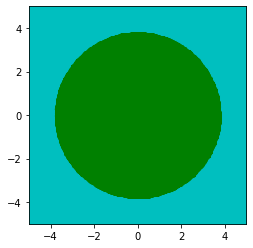

In [7]:
circle_center = (0, 0)
circle_radius = 4

c = plt.Circle(circle_center, circle_radius, fc='w', ec='b')

a = plt.axes(xlim=(-5, 5), ylim=(-5, 5))
a.add_patch(c)
a.set_aspect('equal')

# 원 안의 점을 green으로 색칠
coords = np.array([(x, y) for (x, y), i in results.items() if i == 1])
plt.plot(coords[:, 0], coords[:, 1], color='g', ls='', marker='o')

# 원 밖의 점을 cyan으로 색칠
coords = np.array([(x, y) for (x, y), i in results.items() if i == 0])
plt.plot(coords[:, 0], coords[:, 1], color='c', ls='', marker='o')

plt.show()

# 1. Predict (Sub-Text: RL과 Policy Evaluation)
- Monte-Carlo Prediction
- Temporal Difference

## 1-1. Monte-Carlo Prediction
- 강화학습에서 Predict는 Policy Evaluation을 옮겨온 것.
- PE에선 뭘 계산했었지? $\rightarrow$ 벨만 기대 방정식을 통해 가치 함수(보상의 기댓값)를 계산
- 그러면, 샘플링을 통해 기댓값을 계산하지 않고 샘플들의 평균으로 참 가치함수를 `예측`하려면?
    - 현재 정책에 따라서 계속 행동해보거라 닝겐이여!

### 수식
- In Policy Iteration,
$$v_\pi(s)=E_\pi\big[R_{t+1}+\gamma v_\pi(S_{t+1})\;\big|\;S_t=s\big]$$
$$v_\pi(s)=\sum_{a\in A}\pi(a|s)\big(r_{(s,a)}+\gamma\sum_{s^\prime\in S}P_{SS^\prime}^{a}v_\pi(s^\prime)\big)$$

    - 위의 `벨만 기대 방정식`을 계산하기 위해선 환경의 모델인 `상태 변환 확률` $P_{SS^\prime}^{a}$과 `보상 함수` $r_{(s,a)}$를 알아야 함
- In Monte-Carlo Prediction,
$$v_\pi(s)\;\text{~}\;\frac{1}{N(s)}\sum_{i=1}^{N(s)}G_i(s)$$
    - $N(s)$: 상태 $s$를 여러 번의 에피소드 동안 방문한 횟수
    - $G_i(s)$: 그 상태를 방문한 $i$번째 에피소드에서 $s$의 반환값
- 현재의 정책에 따라 무수히 많은 에피소드를 진행해 보는 것.
    - 그러면 지날 수 있는 모든 상태에 대해 충분한 반환값을 모을 수 있음
- 상태의 반환값들의 평균을 취하는 방법! (식을 변환하여 재귀적으로 써보자!)
    - 아래 가치 함수를 대문자로 표현하는 것은 **참 가치함수가 아니라 측정된 오차가 내포된 가치함수란 의미** 
$$\begin{array}\
V_{n+1}&=\frac{1}{n}\sum_{i=1}^{n}G_i\\
&=V_n+\frac{1}{n}(G_n-V_n)\\
\end{array}$$

- 하여 식을 아래와 같이 정리 가능
$$Hence.\;V(s)\leftarrow V(s)+\frac{1}{n}(G(s)+V(s))$$
    - $G(s)-V(s)$: 오차
    - $\frac{1}{n}$: step size, 업데이트할 때 오차의 얼마를 가지고 업데이트할 지 정하는 것
    - StepSize를 $\alpha$로 보통 씀!


**정말 중요한 것은!!!!**
- 몬테카를로 예측 이후의 모든 강화학습 방법에서 가치함수를 업데이트하는 것은 `위의 수식의 변형`일 뿐!

### 즉, 정리해보면
1. $G(s)$: 업데이트의 목표
2. $\alpha(G(s)-V(s))$: 업데이트의 크기


- 가치함수는 한번에 목표점으로 가는 것이 아닌 `2`만큼 이동하여 자신을 업데이트

## 1-2. Temporal Difference
- 강화학습에서 가장 중요한 아이디어 중 하나
- **MC의 단점은? 실시간이 아니다!**'
    - 가치함수를 업데이트하기 위해서는 에피소드가 끝날 때까지 기다려야 함
- 에피소드가 긴 경우, 혹은 끝이 없는 경우엔 다른 학습 방법, TD를 이용해야 함!

### What is TD?
- MC와 다르게 Time-Step마다 가치함수를 업데이트
- MC에서는 기댓값을 계산하는 대신, Sampling을 통해 예측
- Time-Step마다 $R_{t+1}+\gamma v_\pi(s^\prime)$ 값을 샘플링해서 그 값으로 현재의 가치함수를 업데이트
$$V(S_t)\leftarrow V(S_t)+\alpha(R_{t+1}+\gamma V(S_{t+1})-V(S_t)$$

### 즉,
1. $R_{t+1}+\gamma V(S_{t+1})$: 업데이트의 목표
2. $\alpha\big(R_{t+1}+\gamma V(S_{t+1})-V(S_t)\big)$: 업데이트의 크기

- $R_{t+1}+\gamma V(S_{t+1})-V(S_t)$: `Temporal-Difference Error(시간차 에러)`
- TD는 에피소드가 끝날 때까지 기다릴 필요없이 바로 가치함수를 업데이트할 수 있음
- MC보다 더 효율적으로 빠른 시간 안에 참 가치함수에 근접하지만, **초기 가치함수 값에 따라 예측 정확도가 많이 달라짐**

# 2. RL Algorithm
- SARSA
- Q-Learning

## 2-1. SARSA
